In [1]:
import pymc as pm
import csv
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats

# Temperature/TFP Model

In [68]:
local_data = pd.read_csv("data/processed/country_temp_tfp_output.csv")

In [78]:
with pm.Model() as model:
    
    temp_prior = pm.Normal("temp_prior", 0, 10)
    temp_std = pm.HalfNormal("temp_std", 10)
    temp_posterior = pm.Normal("temp_posterior", temp_prior, temp_std, observed=local_data["Temp_change"])
    
    temp_coef = pm.Normal('temp_coef',0,10)
    temp_coef_2 = pm.Normal('temp_coef_2',0,10)
    temp_intercept = pm.Normal('temp_intercept',0,10)
    
    tfp_prior = pm.Deterministic("tfp_prior", temp_intercept + (temp_coef * temp_posterior) + (temp_coef_2 * pt.sqr(temp_posterior)))
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std, observed=local_data["ln_TFP_change"])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/model.py:1363: ImputationWarning: Data in tfp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x16C356F20>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable Random

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17FC9D040>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
/Users/hayden.freedman/miniconda3/envs/env-data-modeling/lib/python3.9/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17F608740>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [temp_posterior_observed, tfp_posterior_observed, tfp_posterior_unobserved]


/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_49521/4201237373.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


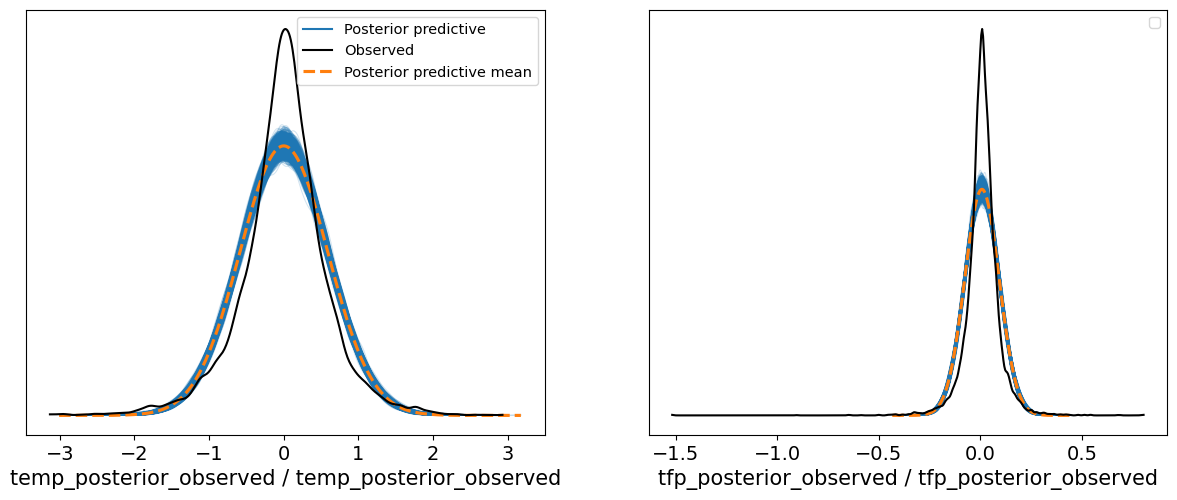

In [81]:
# fig = az.plot_ppc(prior, group="prior").ravel()[0].figure
# fig.show()
# fig = az.plot_trace(trace).ravel()[0].figure
# fig.show()
fig = az.plot_ppc(posterior).ravel()[0].figure
fig.show()

In [87]:
coef1 = np.mean(posterior["posterior"]["temp_coef"][0].data)
coef2 = np.mean(posterior["posterior"]["temp_coef_2"][0].data)
intercept = np.mean(posterior["posterior"]["temp_intercept"][0].data)

-0.005866685175919409 -6.12291618814729e-05 0.007176848804075051


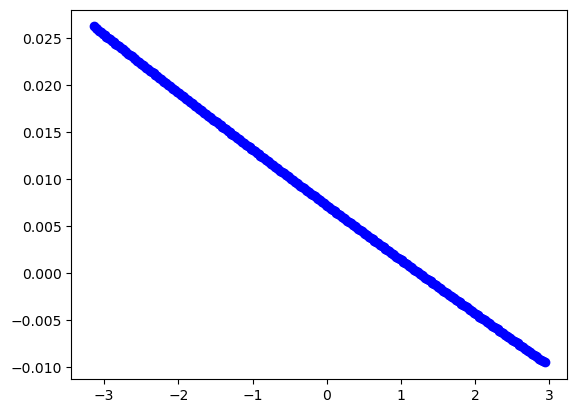

In [94]:
# takes some time to run due to the nested loops
x_vals = []
regression_y_vals = []
sampled_y_vals = []
observed_y_vals = []

for temp in np.linspace(np.nanmin(local_data["Temp_change"]),np.nanmax(local_data["Temp_change"]),num=250):  
    x_vals.append(temp)
    regression_y_vals.append((coef1 * temp) - (coef2 * (temp**2)) + intercept)
    # sampled_tfp_change = []
    # for sample in range(len(local_data["Temp_change"])):
    #     temp_val = posterior["posterior"]["temp_posterior"][0].data[0][sample]
    #     if temp_val >= temp-.08 and temp_val <= temp+.08:
    #         sampled_tfp_change.append(posterior["posterior"]["tfp_posterior"][0].data[0][sample])
    # sampled_y_vals.append(np.mean(sampled_tfp_change))
    # observed_tfp_change = []
    # for index, observed_temp in enumerate(local_data["Temp_change"]):
    #     if observed_temp >= temp-.08 and observed_temp <= temp+.08:
    #         if not np.isnan(local_data["GDP_change"][index]):
    #             observed_gdp_change.append(local_data["GDP_change"][index])
    # observed_y_vals.append(np.mean(observed_gdp_change))

plt.scatter(x_vals, regression_y_vals, color="blue")
# plt.scatter(x_vals, sampled_y_vals, color="red")
# plt.scatter(x_vals, observed_y_vals, color="green")
plt.show()

# Preprocess temp and tfp data

In [3]:
output_dict = {"Country":[],"Year":[],"Temp":[],"TFP":[],"TFP_Change":[],"ln_TFP":[],"Temp_change":[],"ln_TFP_change":[]}
tfp_data = pd.read_csv("../data/ortiz-bobea/data/TFP_USDA/tfp_data.csv")
weather_data = pd.read_csv("../data/ortiz-bobea/data2/Princeton_co/weather_data.csv")
for country in sorted(list(set(weather_data["ISO3"]).intersection(set(tfp_data["WDI Code"])))):
    for year in range(1961,2017,1):
            tfp_val = float(str(tfp_data.loc[(tfp_data["WDI Code"] == country)][str(year)].item()).replace(",",""))
            min_temp_vals = list(weather_data.loc[(weather_data["ISO3"] == country) & (weather_data["year"] == year)]["tmin"])
            max_temp_vals = list(weather_data.loc[(weather_data["ISO3"] == country) & (weather_data["year"] == year)]["tmax"])
            avg_temp_val = np.mean([np.mean([min_temp_vals[i],max_temp_vals[i]]) for i in range(len(min_temp_vals))])
            output_dict["Country"].append(country)
            output_dict["Year"].append(year)
            output_dict["Temp"].append(avg_temp_val)
            output_dict["TFP"].append(tfp_val)
            output_dict["ln_TFP"].append(np.log(tfp_val))
            if len(output_dict["Country"]) > 1 and output_dict["Country"][-2] == country:
                output_dict["Temp_change"].append(avg_temp_val - output_dict["Temp"][-2])
                output_dict["ln_TFP_change"].append(np.log(tfp_val)-output_dict["ln_TFP"][-2])
                output_dict["TFP_Change"].append(tfp_val - output_dict["TFP"][-2])
            else:
                output_dict["Temp_change"].append(np.NaN)
                output_dict["ln_TFP_change"].append(np.NaN)
                output_dict["TFP_Change"].append(np.NaN)
pd.DataFrame.from_dict(output_dict).to_csv("../data/processed/ortiz_bobea_country_temp_tfp_output.csv")

OSError: Cannot save file into a non-existent directory: 'data/processed'